# CSW MetaLearning Branch

The main (only) difference in CSWML is the inclusion of pr_shift as a pararmeter which controls stimulus generation. otherwise it is the same as backpropagating manystories.

In [1]:
import numpy as np
from glob import glob as glob

from cswsims import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Multistory backprop

In [2]:
lstm_size = 50 
nstories = 3
ML = MetaLearner(lstm_size,nstories)

shiftpr = 0.5
trainer = Trainer(ML,shift_pr=shiftpr,graph_pr=1)
eval_data = trainer.train_loop(5000)

initializing sub01
SGD01
0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0


In [3]:
yhat_data = eval_data['yhat']

##### evalpath = 1
- 10 0 2 4 6 8 9 
- 11 0 2 3 6 7 9
- 10 0 2 4 6 8 9

## network predictions

Text(0.5,0.98,'ROW = story, COL = transition')

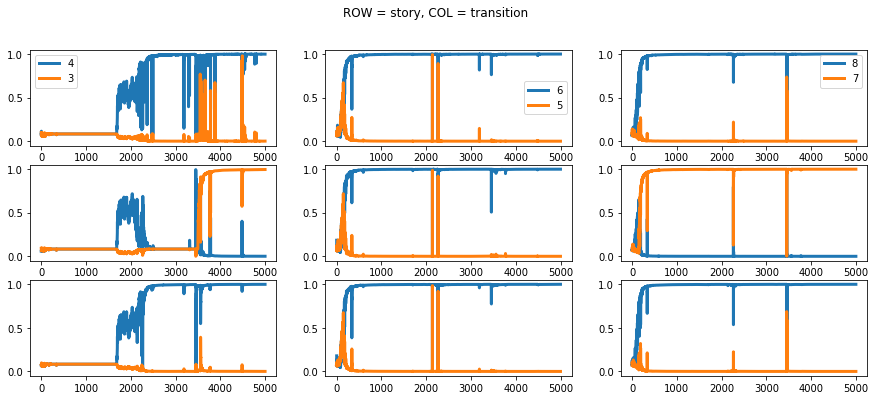

In [4]:
path = 1
tonodeD = {0:(0),1:(1,2),2:(4,3),3:(6,5),4:(8,7),5:(9),6:(10,11)}
fig,axarr= plt.subplots(3,3,figsize=(15,2*3)); 

for transition in [2,3,4]:
  xidx = transition-2
  for story in range(3):
    depth = story*7 + transition
    tonodes=tonodeD[transition]
    axarr[story,xidx].plot(yhat_data[:,path,depth,tonodes[0]],label=tonodes[0],lw=3)
    axarr[story,xidx].plot(yhat_data[:,path,depth,tonodes[1]],label=tonodes[1],lw=3)
    axarr[story,xidx].set_ylim(-.05,1.05)
  axarr[0,xidx].legend()
  
plt.ylim(-.05,1.05)
ax = axarr[0,0]
plt.suptitle('ROW = story, COL = transition')
# plt.savefig('figures/ABAstories-all_transitions-shiftpr_%i_3'%(shiftpr*100))

## fgate analysis

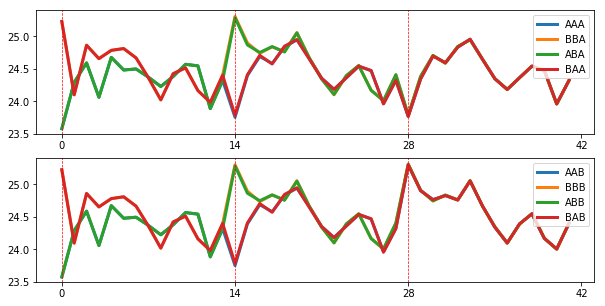

In [126]:
fig,axarr = plt.subplots(2,1,figsize=(10,5)); axarr=axarr.reshape(-1)

for seq in ['AAA','BBA','ABA','BAA']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  axarr[0].plot(sum_fgate,label=seq,lw=3)

for seq in ['AAB','BBB','ABB','BAB']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  axarr[1].plot(sum_fgate,label=seq,lw=3)


for ax in axarr:
  for t in range(0,42,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(23.5,25.4)
  ax.set_xticks(np.arange(0,43,14))
  
# plt.savefig('figures/fgate not modulated by context')

In [154]:

fgate_dataD = {}

for seq in ['BBA','BAA','AAB','ABB','ABA','BAB']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  fgate_dataD[seq] = sum_fgate

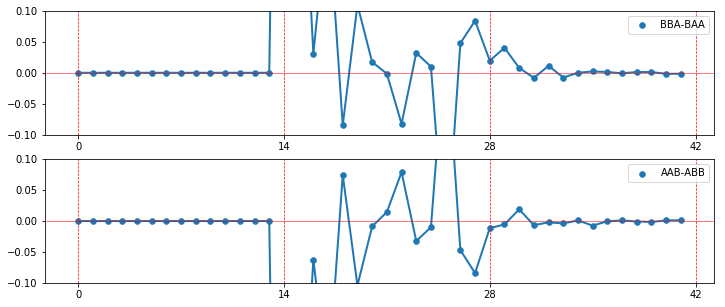

In [151]:
fig,axarr = plt.subplots(2,1,figsize=(12,5)); axarr=axarr.reshape(-1)


axarr[0].plot(fgate_dataD['BBA']-fgate_dataD['BAA'],lw=2)
axarr[0].scatter(range(42),fgate_dataD['BBA']-fgate_dataD['BAA'],lw=.5,label='BBA-BAA')
axarr[1].plot(fgate_dataD['AAB']-fgate_dataD['ABB'],lw=2)
axarr[1].scatter(range(42),fgate_dataD['AAB']-fgate_dataD['ABB'],lw=.5,label='AAB-ABB')

for ax in axarr:
  for t in range(0,43,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(-.1,.1)
  ax.set_xticks(np.arange(0,43,14))
  ax.axhline(0,c='r',lw=.5)
plt.savefig('figures/context_effect_on_fgate')

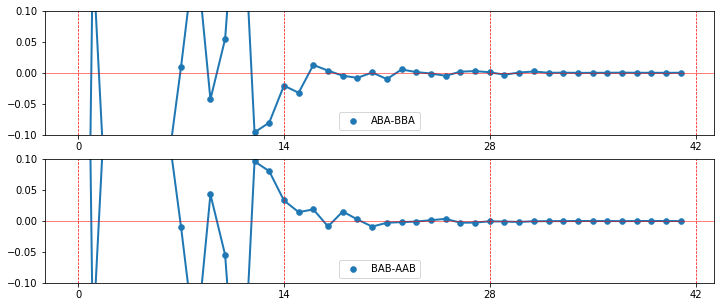

In [158]:
fig,axarr = plt.subplots(2,1,figsize=(12,5)); axarr=axarr.reshape(-1)

seq1,seq2='ABA','BBA'
axarr[0].plot(fgate_dataD[seq1]-fgate_dataD[seq2],lw=2)
axarr[0].scatter(range(42),fgate_dataD[seq1]-fgate_dataD[seq2],lw=.5,label='%s-%s'%(seq1,seq2))
seq1,seq2='BAB','AAB'
axarr[1].plot(fgate_dataD[seq1]-fgate_dataD[seq2],lw=2)
axarr[1].scatter(range(42),fgate_dataD[seq1]-fgate_dataD[seq2],lw=.5,label='%s-%s'%(seq1,seq2))

for ax in axarr:
  for t in range(0,43,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(-.1,.1)
  ax.set_xticks(np.arange(0,43,14))
  ax.axhline(0,c='r',lw=.5)
plt.savefig('figures/2stepcontext_effect_on_fgate')

## multiple networks fgate analysis

In [8]:
lstm_size = 50 
nstories = 3
nepochs = 5000
graphpr = 1
shiftpr = 0.2

nnets = 3
ML = MetaLearner(lstm_size,nstories)
for netn in range(nnets):
  ML.reinitialize()
  trainer = Trainer(ML,shift_pr=shiftpr,graph_pr=graphpr)
  train_data = trainer.train_loop(nepochs)
  for seq in ['AAA','ABA','BAA','BBA']:
    Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
    evalstep_data = trainer.eval_step(Xeval,Yeval)
    fpath = 'eval_data/S%i-shift_%i-seq_%s'%(netn,100*shiftpr,seq)
    np.save(fpath,evalstep_data)

initializing sub01
SGD01
**reinitializing weights** - incremental seeds
reinitializing sub02
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
**reinitializing weights** - incremental seeds
reinitializing sub03
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


In [92]:
L = []
fpathL = glob('eval_data/*')
D={20:{},80:{},50:{}}
print(fpathL[0])
for fpath in fpathL:
  netn = int(fpath.split('/')[-1].split('-')[0][1])
  prshift = int(fpath.split('/')[-1].split('-')[1].split('_')[1])
  seq = fpath.split('_')[-1].split(".")[0]
  print(netn,prshift,seq,'\n',fpath)
  if seq not in D[prshift]: D[prshift][seq] = []
  eval_data = np.load(fpath)
  fgate_data = np.sum(eval_data['fgate'].squeeze(),1)
  D[prshift][seq].append(fgate_data)

eval_data/S7-shift_80-seq_BBA.npy
7 80 BBA 
 eval_data/S7-shift_80-seq_BBA.npy
9 80 ABA 
 eval_data/S9-shift_80-seq_ABA.npy
1 80 BAA 
 eval_data/S1-shift_80-seq_BAA.npy
4 80 BAA 
 eval_data/S4-shift_80-seq_BAA.npy
2 80 BBA 
 eval_data/S2-shift_80-seq_BBA.npy
5 80 AAA 
 eval_data/S5-shift_80-seq_AAA.npy
3 80 ABA 
 eval_data/S3-shift_80-seq_ABA.npy
8 80 BBA 
 eval_data/S8-shift_80-seq_BBA.npy
6 80 ABA 
 eval_data/S6-shift_80-seq_ABA.npy
0 80 AAA 
 eval_data/S0-shift_80-seq_AAA.npy
5 20 BAA 
 eval_data/S5-shift_20-seq_BAA.npy
3 20 BBA 
 eval_data/S3-shift_20-seq_BBA.npy
8 20 ABA 
 eval_data/S8-shift_20-seq_ABA.npy
6 20 BBA 
 eval_data/S6-shift_20-seq_BBA.npy
0 50 BAA 
 eval_data/S0-shift_50-seq_BAA.npy
0 20 BAA 
 eval_data/S0-shift_20-seq_BAA.npy
7 20 ABA 
 eval_data/S7-shift_20-seq_ABA.npy
9 20 BBA 
 eval_data/S9-shift_20-seq_BBA.npy
1 20 AAA 
 eval_data/S1-shift_20-seq_AAA.npy
4 20 AAA 
 eval_data/S4-shift_20-seq_AAA.npy
2 20 ABA 
 eval_data/S2-shift_20-seq_ABA.npy
2 80 ABA 
 eval_data/

TypeError: return arrays must be of ArrayType

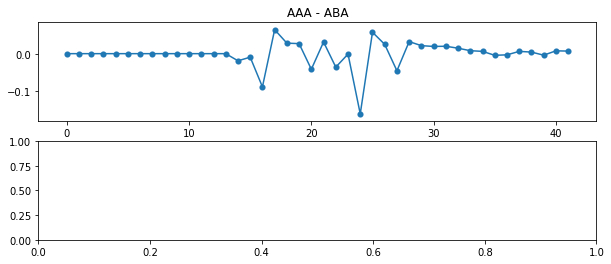

In [103]:
fig,axarr = plt.subplots(2,1,figsize=(10,4));axarr=axarr.reshape(-1)
ax = plt.gca()

seq1,seq2 = 'AAA','ABA'
for shiftpr in [20,80]:
  axarr[0].set_title('%s - %s'%(seq1,seq2))
  diff = np.mean(D[shiftpr][seq1],0) - np.mean(D[shiftpr][seq2],0)
  axarr[0].plot(diff,label = '%i'%(shiftpr))
  axarr[0].scatter(range(42),diff,lw=.1)
  std_err = np.std(D[shiftpr][seq1],0)/np.sqrt(len(D[shiftpr][seq1]))
  print(std_err.shape)
  axarr[1].bar(range(14),diff[-14:],yerr=std_err)

axarr[1].axhline(0)
ax = axarr[0]
for t in range(0,43,14):
  ax.axvline(t,c='r',ls='--',lw=.7)
ax.axhline(0,c='r',ls='--',lw=.7)
# ax.set_ylim(-.3,.1)
plt.legend()

10